# Import Library

In [2]:
import datetime
import json
import requests
import holidays
from tqdm import tqdm

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import interpolate

# Preprocessing International Trade Table

## Load Data 

In [3]:
trade=pd.read_csv('./data/international_trade.csv')
trade

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
0,2019-01,토마토(신선한 것이나 냉장한 것으로 한정한다),356571,990,0,0,990
1,2019-01,양파,821330,222,4003206,1118,-896
2,2019-01,쪽파,60,1,93405,128,-127
3,2019-01,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562
4,2019-01,방울다다기 양배추,0,0,7580,38,-38
...,...,...,...,...,...,...,...
1269,2023-02,포포(papaw)[파파야(papaya)],0,0,23830,71,-71
1270,2023-02,사과,135165,351,0,0,351
1271,2023-02,배,2206012,5411,1,0,5411
1272,2023-02,신 체리[프루너스 체라서스(Prunus cerasus)],5,0,0,0,0


## Switch Columns to ENG

In [4]:
trade.columns=['timestamp', 'item', 'expo_quantity', 'expo_rev',
              'impo_quantity','impo_cost','margin']
trade

,timestamp,item,expo_quantity,expo_rev,impo_quantity,impo_cost,margin
0,2019-01,토마토(신선한 것이나 냉장한 것으로 한정한다),356571,990,0,0,990
1,2019-01,양파,821330,222,4003206,1118,-896
2,2019-01,쪽파,60,1,93405,128,-127
3,2019-01,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562
4,2019-01,방울다다기 양배추,0,0,7580,38,-38
...,...,...,...,...,...,...,...
1269,2023-02,포포(papaw)[파파야(papaya)],0,0,23830,71,-71
1270,2023-02,사과,135165,351,0,0,351
1271,2023-02,배,2206012,5411,1,0,5411
1272,2023-02,신 체리[프루너스 체라서스(Prunus cerasus)],5,0,0,0,0


## Switch Item to ENG

In [5]:
trade['item'].unique()

array(['토마토(신선한 것이나 냉장한 것으로 한정한다)', '양파', '쪽파', '꽃양배추와 브로콜리(broccoli)',
       '방울다다기 양배추', '양배추', '결구(結球) 상추',
       '위트루프 치커리(Witloof chicory)[시코리엄 인티부스 변종 포리오섬(Cichorium intybus var. foliosum)]',
       '당근', '오이류(신선한 것이나 냉장한 것으로 한정한다)',
       '콩[비그나(Vigna)속ㆍ파세러스(Phaseolus)속)]', '대추야자', '무화과', '파인애플',
       '망고(mango)', '망고스틴(mangosteen)', '오렌지', '감귤',
       '그레이프프루트(grapefruit)와 포멜로(pomelo)',
       '레몬[시트러스 리몬(Citrus limon)ㆍ시트러스 리머늄(Citrus limonum)]', '수박',
       '포포(papaw)[파파야(papaya)]', '사과', '배', '자두',
       '완두[피섬 새티범(Pisum sativum)]', '구아바(guava)', '살구',
       '신 체리[프루너스 체라서스(Prunus cerasus)]', '복숭아[넥터린(nectarine)을 포함한다]',
       '순무', '방울토마토', '샬롯(shallot)', '참외'], dtype=object)

In [6]:
en_dict={'토마토(신선한 것이나 냉장한 것으로 한정한다)':'TM',
        '양파':'ON','쪽파':'SL','꽃양배추와 브로콜리(broccoli)':'BC',
         '방울다다기 양배추':'BS', '양배추':'CB', '결구(結球) 상추':'LT',
        '위트루프 치커리(Witloof chicory)[시코리엄 인티부스 변종 포리오섬(Cichorium intybus var. foliosum)]':'CH',
        '당근':'CR', '오이류(신선한 것이나 냉장한 것으로 한정한다)':'CC',
        '콩[비그나(Vigna)속ㆍ파세러스(Phaseolus)속)]':'BE',
        '대추야자':'DP', '무화과':'FG', '파인애플':'PA', '망고(mango)':'MG',
        '망고스틴(mangosteen)':'MS', '오렌지':'OR', '감귤':'TG',
        '그레이프프루트(grapefruit)와 포멜로(pomelo)':'GP',
        '레몬[시트러스 리몬(Citrus limon)ㆍ시트러스 리머늄(Citrus limonum)]':'LM',
        '수박':'WM','포포(papaw)[파파야(papaya)]':'PP', '사과':'AP', '배':'PR', '자두':'PU',
        '완두[피섬 새티범(Pisum sativum)]':'BN', '구아바(guava)':'GV','살구':'AC',
        '신 체리[프루너스 체라서스(Prunus cerasus)]':'CE','복숭아[넥터린(nectarine)을 포함한다]':'PC',
        '순무':'TN','방울토마토':'CT','샬롯(shallot)':'ST','참외':'OM'}

for idx in range(len(trade)):
    trade.loc[idx,'item']=en_dict[trade.loc[idx,'item']]
trade

,timestamp,item,expo_quantity,expo_rev,impo_quantity,impo_cost,margin
0,2019-01,TM,356571,990,0,0,990
1,2019-01,ON,821330,222,4003206,1118,-896
2,2019-01,SL,60,1,93405,128,-127
3,2019-01,BC,160,1,638913,563,-562
4,2019-01,BS,0,0,7580,38,-38
...,...,...,...,...,...,...,...
1269,2023-02,PP,0,0,23830,71,-71
1270,2023-02,AP,135165,351,0,0,351
1271,2023-02,PR,2206012,5411,1,0,5411
1272,2023-02,CE,5,0,0,0,0


In [7]:
trade.to_csv('./data/preprocessed_trade.csv', index=False)

# Preprocessing Selling Data

## Load Data

In [8]:
selling=pd.read_csv('./data/train.csv')
selling

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0
...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0


## Simplify Columns

In [9]:
selling.columns=['id','timestamp','item','co_op','loc','supply','price']
selling

,id,timestamp,item,co_op,loc,supply,price
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0
...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0


In [10]:
corr=selling[selling['price']>0].corr(numeric_only=True)
corr

,supply,price
supply,1.000000,-0.269416
price,-0.269416,1.000000


C:\Users\USER\AppData\Local\Temp\ipykernel_11220\2629997647.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(sell.corr(numeric_only=True), dtype=np.bool)


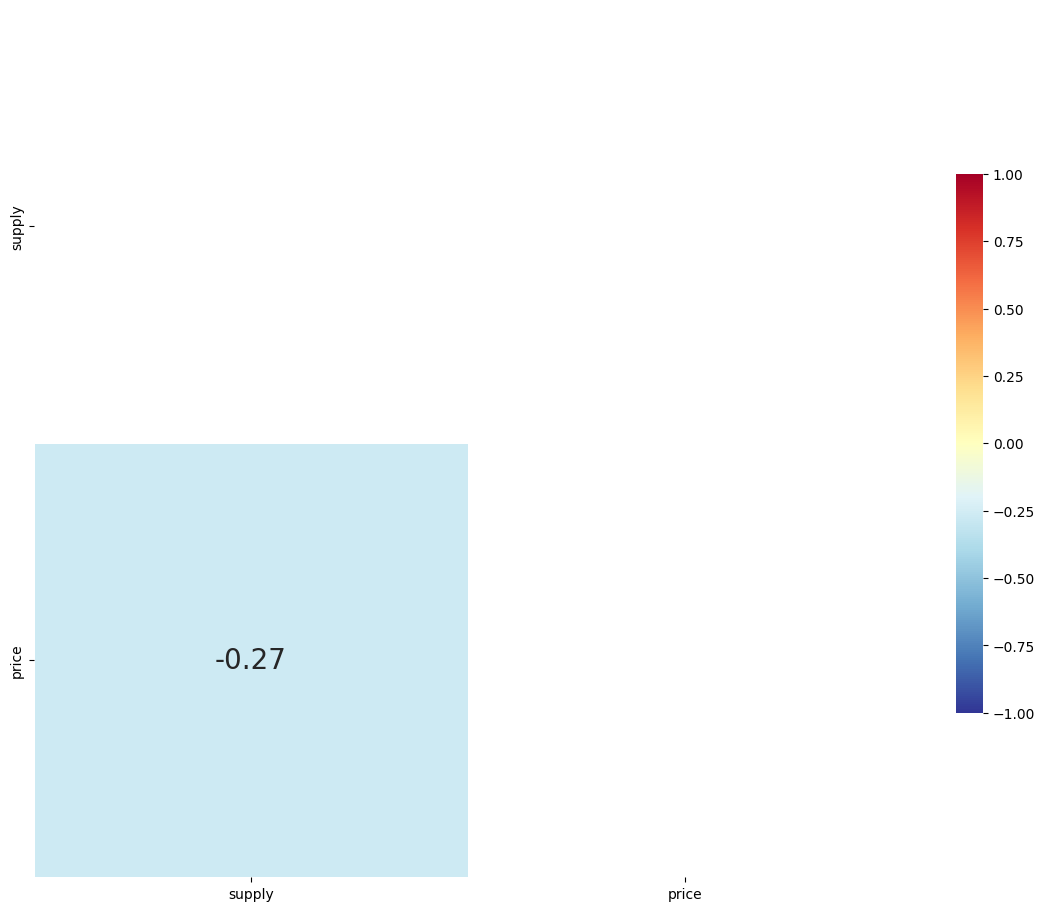

In [11]:
fig, ax = plt.subplots( figsize=(14,14) )
sell=selling[['supply','price']]

mask = np.zeros_like(sell.corr(numeric_only=True), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

test_heatmap = sns.heatmap(corr.values,
                          cbar = True,
                           cbar_kws={"shrink": .5},
                           cmap = 'RdYlBu_r',
                           annot = True,
                          annot_kws={'size' : 20},
                           mask=mask,
                           fmt = '.2f',
                           square = 'True',
                           linewidths=.5,
                          yticklabels=sell.columns,
                          xticklabels=sell.columns,
                          vmin = -1,vmax = 1)
plt.show()

## Set Dateformat & Extract Date Data

In [12]:
selling["timestamp"] = pd.to_datetime(selling["timestamp"])
selling['year']=selling['timestamp'].dt.year
selling['month']=selling['timestamp'].dt.month
selling['week'] = selling['timestamp'].apply(lambda x: x.isocalendar()[1])
selling['day']=selling['timestamp'].dt.weekday
selling['yemon']=selling['timestamp'].dt.strftime('%Y-%m')
selling

,id,timestamp,item,co_op,loc,supply,price,year,month,week,day,yemon
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,1,2019-01
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,1,2,2019-01
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,1,3,2019-01
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,1,4,2019-01
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,1,5,2019-01
...,...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0,2023,2,9,0,2023-02
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0,2023,2,9,1,2023-02
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0,2023,3,9,2,2023-03
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0,2023,3,9,3,2023-03


## Add Holiday Column

C:\Users\USER\AppData\Local\Temp\ipykernel_11220\3449508076.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=selling,
C:\Users\USER\AppData\Local\Temp\ipykernel_11220\3449508076.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,'Mon','Tue','Wed','Thu','Fri','Sat','Sun'])


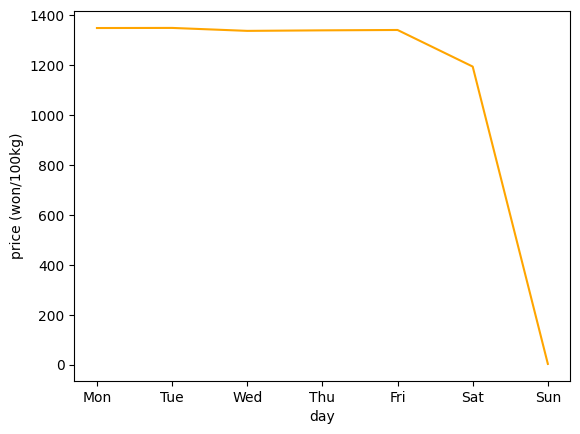

In [13]:
sns.lineplot(data=selling,
             x='day',
             y='price',
             ci=None,
            color='orange')
plt.xlabel('day')
ax = plt.gca()
ax.set_xticklabels([0,'Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.ylabel('price (won/100kg)')
plt.show()

In [10]:
kr_holidays = holidays.KR()
selling['holiday'] = selling['timestamp'].apply(lambda x: 1 if x in kr_holidays else 0)
selling

,id,timestamp,item,co_op,loc,supply,price,year,month,week,day,yemon,holiday
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,1,2019-01,1
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,1,2,2019-01,0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,1,3,2019-01,0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,1,4,2019-01,0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,1,5,2019-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0,2023,2,9,0,2023-02,0
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0,2023,2,9,1,2023-02,0
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0,2023,3,9,2,2023-03,1
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0,2023,3,9,3,2023-03,0


In [11]:
# 공휴일이면서 거래 내역 있는 데이터의 holiday 컬럼 0으로
for idx in range(len(selling)):
    if (selling.loc[idx,'holiday']==1) & (selling.loc[idx,'price']!=0):
        selling.loc[idx,'holiday']=0
selling

,id,timestamp,item,co_op,loc,supply,price,year,month,week,day,yemon,holiday
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,1,2019-01,1
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,1,2,2019-01,0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,1,3,2019-01,0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,1,4,2019-01,0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,1,5,2019-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0,2023,2,9,0,2023-02,0
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0,2023,2,9,1,2023-02,0
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0,2023,3,9,2,2023-03,0
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0,2023,3,9,3,2023-03,0


## Scaling Numeric Data
### * supply : 100kg 단위 -> price : 원/100kg

In [34]:
selling[selling['price']==0]

,id,timestamp,item,co_op,loc,supply,price,year,month,week,day,yemon,holiday
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,1,2019-01,1
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,1,2,2019-01,0
5,TG_A_J_20190106,2019-01-06,TG,A,J,0.0,0.0,2019,1,1,6,2019-01,0
12,TG_A_J_20190113,2019-01-13,TG,A,J,0.0,0.0,2019,1,2,6,2019-01,0
19,TG_A_J_20190120,2019-01-20,TG,A,J,0.0,0.0,2019,1,3,6,2019-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59363,RD_F_J_20230129,2023-01-29,RD,F,J,0.0,0.0,2023,1,4,6,2023-01,0
59370,RD_F_J_20230205,2023-02-05,RD,F,J,0.0,0.0,2023,2,5,6,2023-02,0
59377,RD_F_J_20230212,2023-02-12,RD,F,J,0.0,0.0,2023,2,6,6,2023-02,0
59384,RD_F_J_20230219,2023-02-19,RD,F,J,0.0,0.0,2023,2,7,6,2023-02,0


In [12]:
for idx in tqdm(range(len(selling))):
    selling.loc[idx,'supply']=round(selling.loc[idx,'supply']/100,2)
    selling.loc[idx,'price']=round(selling.loc[idx,'price']/100,2)
selling

,id,timestamp,item,co_op,loc,supply,price,year,month,week,day,yemon,holiday
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.00,0.00,2019,1,1,1,2019-01,1
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.00,0.00,2019,1,1,2,2019-01,0
2,TG_A_J_20190103,2019-01-03,TG,A,J,606.01,17.28,2019,1,1,3,2019-01,0
3,TG_A_J_20190104,2019-01-04,TG,A,J,250.00,14.08,2019,1,1,4,2019-01,0
4,TG_A_J_20190105,2019-01-05,TG,A,J,323.52,12.50,2019,1,1,5,2019-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,4524.40,4.68,2023,2,9,0,2023-02,0
59393,RD_F_J_20230228,2023-02-28,RD,F,J,4219.80,5.31,2023,2,9,1,2023-02,0
59394,RD_F_J_20230301,2023-03-01,RD,F,J,3829.80,5.74,2023,3,9,2,2023-03,0
59395,RD_F_J_20230302,2023-03-02,RD,F,J,4772.20,5.23,2023,3,9,3,2023-03,0


In [32]:
selling[(selling['day']==5)&(selling['supply']==0)][:50]

,id,timestamp,item,co_op,loc,supply,price,year,month,week,day,yemon,holiday
95,TG_A_J_20190406,2019-04-06,TG,A,J,0.0,0.0,2019,4,14,5,2019-04,0
109,TG_A_J_20190420,2019-04-20,TG,A,J,0.0,0.0,2019,4,16,5,2019-04,0
116,TG_A_J_20190427,2019-04-27,TG,A,J,0.0,0.0,2019,4,17,5,2019-04,0
123,TG_A_J_20190504,2019-05-04,TG,A,J,0.0,0.0,2019,5,18,5,2019-05,0
137,TG_A_J_20190518,2019-05-18,TG,A,J,0.0,0.0,2019,5,20,5,2019-05,0
144,TG_A_J_20190525,2019-05-25,TG,A,J,0.0,0.0,2019,5,21,5,2019-05,0
158,TG_A_J_20190608,2019-06-08,TG,A,J,0.0,0.0,2019,6,23,5,2019-06,0
165,TG_A_J_20190615,2019-06-15,TG,A,J,0.0,0.0,2019,6,24,5,2019-06,0
172,TG_A_J_20190622,2019-06-22,TG,A,J,0.0,0.0,2019,6,25,5,2019-06,0
179,TG_A_J_20190629,2019-06-29,TG,A,J,0.0,0.0,2019,6,26,5,2019-06,0


In [13]:
selling.to_csv('./data/selling.csv',index=False)

# ASOS Data

## Request ASOS Data

In [37]:
url = 'http://apis.data.go.kr/1360000/AsosDalyInfoService/getWthrDataList'
date=['20180101', '20181231',
      '20190101','20191231',
      '20200101','20201231',
      '20210101','20211231',
      '20220101','20221231',
      '20230101','20230304']
row=['365','365','366','365','365','62']


asos_df=0
for stn in [184,189]:
    df1=0
    for i in tqdm(range(0,len(date),2)):
        params ={'serviceKey' : 'wACC0jmLBit52BZepbj7OeworqNhenCQapfqcO/wJO86y23ikIAIRESSY1u9YOm/PJXYn/D9hQQElLshrtn8zQ==',
                 'pageNo' : '1',
                 'numOfRows' : row[i//2],
                 'dataType' : 'json',
                 'dataCd' : 'ASOS',
                 'dateCd' : 'DAY',
                 'startDt' : date[i],
                 'endDt' : date[i+1],
                 'stnIds' : stn }

        response = requests.get(url, params=params)
        json_ob = json.loads(response.content)
        json_ob=json_ob['response']['body']['items']['item']
        df=pd.DataFrame(json_ob)
        
        if type(df1)!=int:
            df1=pd.concat([df1,df]).reset_index(drop=True)
        else:
            df1=df.copy()
    
    if type(asos_df)!=int:
        asos_df=pd.concat([asos_df,df1]).reset_index(drop=True)
    else:
        asos_df=df1.copy()

asos_df=asos_df[['stnNm','tm','avgTa','minTa','maxTa','sumRn','hr1MaxRn','avgWs','sumSsHr']]
asos_df.columns=['station','timestamp','temperture','mintem','maxtem','raining','hrrain','wind_speed','sunlight_hour']
asos_df

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:08<00:00,  1.38s/it]


,station,timestamp,temperture,mintem,maxtem,raining,hrrain,wind_speed,sunlight_hour
0,제주,2018-01-01,6.4,4.0,8.8,,,3.5,2.7
1,제주,2018-01-02,7.0,3.0,10.1,,,2.2,8.2
2,제주,2018-01-03,5.0,3.5,8.4,,,3.4,3.2
3,제주,2018-01-04,3.9,2.4,4.6,0.6,,2.6,0.0
4,제주,2018-01-05,5.1,1.9,6.5,4.2,,4.1,0.0
...,...,...,...,...,...,...,...,...,...
3771,서귀포,2023-02-27,8.7,4.0,13.2,,,1.3,10.8
3772,서귀포,2023-02-28,11.9,7.2,15.2,,,1.4,9.5
3773,서귀포,2023-03-01,12.0,9.1,14.5,11.5,,1.6,3.3
3774,서귀포,2023-03-02,7.2,4.9,10.5,,,2.2,10.8


In [38]:
asos_df=asos_df.replace('',np.nan)

col = asos_df.columns[2:]
for c in col:
    asos_df[c]=asos_df[c].astype(float)

asos_df

,station,timestamp,temperture,mintem,maxtem,raining,hrrain,wind_speed,sunlight_hour
0,제주,2018-01-01,6.4,4.0,8.8,NaN,NaN,3.5,2.7
1,제주,2018-01-02,7.0,3.0,10.1,NaN,NaN,2.2,8.2
2,제주,2018-01-03,5.0,3.5,8.4,NaN,NaN,3.4,3.2
3,제주,2018-01-04,3.9,2.4,4.6,0.6,NaN,2.6,0.0
4,제주,2018-01-05,5.1,1.9,6.5,4.2,NaN,4.1,0.0
...,...,...,...,...,...,...,...,...,...
3771,서귀포,2023-02-27,8.7,4.0,13.2,NaN,NaN,1.3,10.8
3772,서귀포,2023-02-28,11.9,7.2,15.2,NaN,NaN,1.4,9.5
3773,서귀포,2023-03-01,12.0,9.1,14.5,11.5,NaN,1.6,3.3
3774,서귀포,2023-03-02,7.2,4.9,10.5,NaN,NaN,2.2,10.8


In [39]:
asos_df.info()
# temperture -> 1
# raining -> 2130
# hrrain -> 2839
# sunlight_hour -> 14

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3776 entries, 0 to 3775
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   station        3776 non-null   object 
 1   timestamp      3776 non-null   object 
 2   temperture     3775 non-null   float64
 3   mintem         3776 non-null   float64
 4   maxtem         3776 non-null   float64
 5   raining        1646 non-null   float64
 6   hrrain         937 non-null    float64
 7   wind_speed     3776 non-null   float64
 8   sunlight_hour  3758 non-null   float64
dtypes: float64(7), object(2)
memory usage: 265.6+ KB


<function matplotlib.pyplot.show(close=None, block=None)>

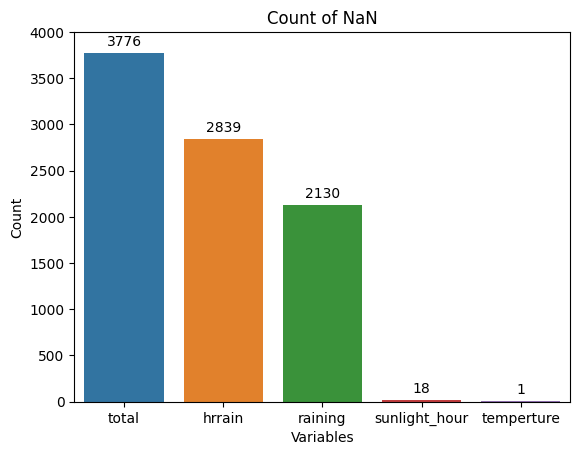

In [82]:
di={'total':len(asos_df),
    'hrrain':asos_df['hrrain'].isnull().sum(),
   'raining':asos_df['raining'].isnull().sum(),
   'sunlight_hour':asos_df['sunlight_hour'].isnull().sum(),
   'temperture':asos_df['temperture'].isnull().sum()}


ax=sns.barplot(x=list(di.keys()),
               y=list(di.values())
              )

ax.set_ylim(0,4000)

for i, v in enumerate(list(di.values())):
    ax.text(i, v + 80, str(v), color='black', ha='center')
    
plt.xlabel('Variables')
plt.ylabel('Count')
plt.title('Count of NaN')

plt.show

In [17]:
jeju=asos_df[:1523]
jeju=jeju.interpolate()
# jeju=jeju.interpolate(method='quadratic')

seogui=asos_df[1523:]
seogui=seogui.interpolate()
# seogui=seogui.interpolate(method='quadratic')
asos_df=pd.concat([jeju,seogui])

asos_df=asos_df.replace(np.nan,'0') # 보간되지 않은 값과 0.0 미만으로 보간된 값은 0으로 처리
asos_df['raining']=asos_df['raining'].astype(float)
for idx in range(len(asos_df)):
    if asos_df.loc[idx,'raining']<0.0:
        asos_df.loc[idx,'raining']=0
asos_df['raining'].where(asos_df['raining'] < 0.0, 0)
asos_df['raining']=asos_df['raining'].round(1)

asos_df['hrrain']=asos_df['hrrain'].astype(float)
for idx in range(len(asos_df)):
    if asos_df.loc[idx,'hrrain']<0.0:
        asos_df.loc[idx,'hrrain']=0
asos_df['hrrain'].where(asos_df['hrrain'] < 0.0, 0)
asos_df['hrrain']=asos_df['hrrain'].round(1)

asos_df

,station,timestamp,temperture,mintem,maxtem,raining,hrrain,wind_speed,sunlight_hour
0,제주,2018-01-01,6.4,4.0,8.8,0.0,0.0,3.5,2.7
1,제주,2018-01-02,7.0,3.0,10.1,0.0,0.0,2.2,8.2
2,제주,2018-01-03,5.0,3.5,8.4,0.0,0.0,3.4,3.2
3,제주,2018-01-04,3.9,2.4,4.6,0.6,0.0,2.6,0.0
4,제주,2018-01-05,5.1,1.9,6.5,4.2,0.0,4.1,0.0
...,...,...,...,...,...,...,...,...,...
3771,서귀포,2023-02-27,8.7,4.0,13.2,8.3,0.0,1.3,10.8
3772,서귀포,2023-02-28,11.9,7.2,15.2,9.9,0.0,1.4,9.5
3773,서귀포,2023-03-01,12.0,9.1,14.5,11.5,0.0,1.6,3.3
3774,서귀포,2023-03-02,7.2,4.9,10.5,11.5,0.0,2.2,10.8


In [ ]:
fig = plt.figure(figsize=(20, 8))

sns.lineplot(data=asos_df[(asos_df['timestamp']>='2018-10-22')&(asos_df['timestamp']<='2018-11-04')&(asos_df['station']=='서귀포')],
             x='timestamp',
             y='sunlight_hour',
             color='blue',
             ci=None)

sns.lineplot(data=asos_dff[(asos_dff['timestamp']>='2018-11-04')&(asos_dff['timestamp']<='2018-11-07')&(asos_dff['station']=='서귀포')],
             x='timestamp',
             y='sunlight_hour',
             color='orange',
             ci=None)

sns.lineplot(data=asos_df[(asos_df['timestamp']>='2018-11-07')&(asos_df['timestamp']<='2018-11-17')&(asos_df['station']=='서귀포')],
             x='timestamp',
             y='sunlight_hour',
             color='blue',
             ci=None)

plt.title('Linear Interpolated Sunlight Hour')
plt.show()

In [19]:
asos_df["timestamp"] = pd.to_datetime(asos_df["timestamp"])
asos_df['year']=asos_df['timestamp'].dt.year
asos_df['month']=asos_df['timestamp'].dt.month
asos_df['week'] = asos_df['timestamp'].apply(lambda x: x.isocalendar()[1])
asos_df['day']=asos_df['timestamp'].dt.weekday
asos_df['yemon']=asos_df['timestamp'].dt.strftime('%Y-%m')
asos_df

,station,timestamp,temperture,mintem,maxtem,raining,hrrain,wind_speed,sunlight_hour,year,month,week,day,yemon
0,제주,2018-01-01,6.4,4.0,8.8,0.0,0.0,3.5,2.7,2018,1,1,0,2018-01
1,제주,2018-01-02,7.0,3.0,10.1,0.0,0.0,2.2,8.2,2018,1,1,1,2018-01
2,제주,2018-01-03,5.0,3.5,8.4,0.0,0.0,3.4,3.2,2018,1,1,2,2018-01
3,제주,2018-01-04,3.9,2.4,4.6,0.6,0.0,2.6,0.0,2018,1,1,3,2018-01
4,제주,2018-01-05,5.1,1.9,6.5,4.2,0.0,4.1,0.0,2018,1,1,4,2018-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3771,서귀포,2023-02-27,8.7,4.0,13.2,8.3,0.0,1.3,10.8,2023,2,9,0,2023-02
3772,서귀포,2023-02-28,11.9,7.2,15.2,9.9,0.0,1.4,9.5,2023,2,9,1,2023-02
3773,서귀포,2023-03-01,12.0,9.1,14.5,11.5,0.0,1.6,3.3,2023,3,9,2,2023-03
3774,서귀포,2023-03-02,7.2,4.9,10.5,11.5,0.0,2.2,10.8,2023,3,9,3,2023-03


In [20]:
asos_df['station']=np.where(asos_df['station']=='제주','J','S')
asos_df

,station,timestamp,temperture,mintem,maxtem,raining,hrrain,wind_speed,sunlight_hour,year,month,week,day,yemon
0,J,2018-01-01,6.4,4.0,8.8,0.0,0.0,3.5,2.7,2018,1,1,0,2018-01
1,J,2018-01-02,7.0,3.0,10.1,0.0,0.0,2.2,8.2,2018,1,1,1,2018-01
2,J,2018-01-03,5.0,3.5,8.4,0.0,0.0,3.4,3.2,2018,1,1,2,2018-01
3,J,2018-01-04,3.9,2.4,4.6,0.6,0.0,2.6,0.0,2018,1,1,3,2018-01
4,J,2018-01-05,5.1,1.9,6.5,4.2,0.0,4.1,0.0,2018,1,1,4,2018-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3771,S,2023-02-27,8.7,4.0,13.2,8.3,0.0,1.3,10.8,2023,2,9,0,2023-02
3772,S,2023-02-28,11.9,7.2,15.2,9.9,0.0,1.4,9.5,2023,2,9,1,2023-02
3773,S,2023-03-01,12.0,9.1,14.5,11.5,0.0,1.6,3.3,2023,3,9,2,2023-03
3774,S,2023-03-02,7.2,4.9,10.5,11.5,0.0,2.2,10.8,2023,3,9,3,2023-03


In [21]:
asos_df.to_csv('./data/asos.csv',index=False)